In [1]:
from gcpds.utils import loaddb
from matplotlib import pyplot as plt
import numpy as np
from scipy.fftpack import fft, fftfreq, fftshift
from scipy.signal import welch
from datetime import datetime, timedelta

db = loaddb.BCI_CIV_2a('BCI2a_database')
db.load_subject(1)
data, _ = db.get_data()
fs = db.metadata['sampling_rate']
data.shape

(273, 22, 1750)

# Frequency filters

In [2]:
from gcpds.filters import frequency as flt

The input data format use the default `trials,channels,time` and the value of the `sampling frequency` in Hertz.

In [3]:
print(f"{data.shape} -> (trials,channels,time)")
print(f"{fs} Hz -> Sampling frequency")

(273, 22, 1750) -> (trials,channels,time)
250 Hz -> Sampling frequency


## Predefined filters

All predefined filters have the order `N=5` (for bandpass) and the quality factor `Q=3` (notch).

There are some predefined filters: `notch60`, `band545`, `band330`, `band245`, `band440`,  `band150`, `band713`, `band1550` and `band550`

There is 2 notch filters: `notch50` and `notch60`

In [112]:
filtered_data = flt.notch60(data, fs=fs)
data.shape, filtered_data.shape

((273, 22, 1750), (273, 22, 1750))

9 EEG common use filters: `band545`, `band330`, `band245`, `band440`, `band150`, `band713`, `band1550`, `band550`, `band1100`

In [96]:
flt.band545(data, fs=fs)  # bandpass 5-45 Hz
flt.band1550(data, fs=fs);  # bandpass 15-50 Hz

and 4 EEG waves filters: `delta`, `theta`, `alpha`, `beta`, `mu` (an alpha alias).

| Filter    | Low frequency | High frequency | Order |
|-----------|---------------|----------------|-------|
| delta     | 2 Hz          | 5 Hz           | 5     |
| theta     | 5 Hz          | 8 Hz           | 5     |
| alpha, mu | 8 Hz          | 12 Hz          | 5     |
| beta      | 13 Hz         | 30 Hz          | 5     |

In [97]:
flt.delta(data, fs=fs)  # bandpass for delta waves
flt.alpha(data, fs=fs);  # bandpass for alpha waves

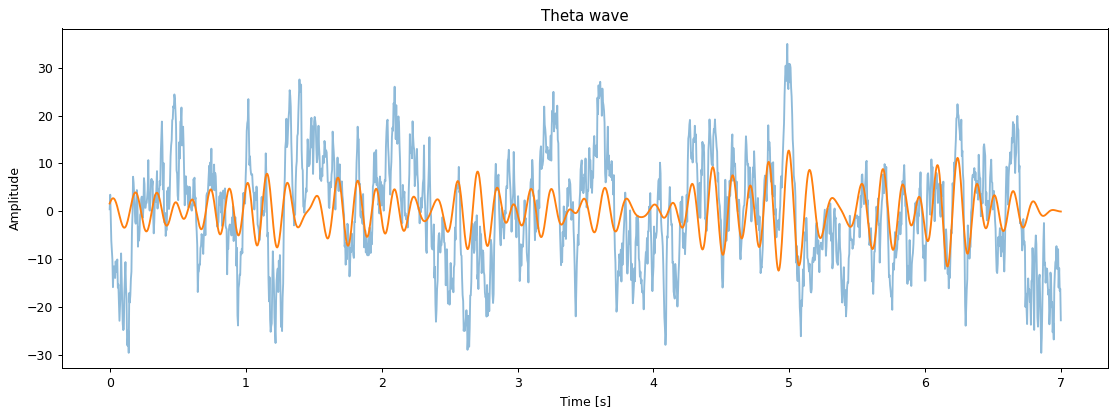

In [110]:
plt.figure(figsize=(15, 5), dpi=90)

t = np.arange(data.shape[2]) / fs
plt.plot(t, data[0, 0], alpha=0.5)
plt.plot(t, flt.theta(data, fs=fs)[0, 0])

plt.title('Theta wave')
plt.ylabel('Amplitude')
plt.xlabel('Time [s]')
plt.show()

## Recompile predefined filters

In order to change the default `order` or the `quality factor` for predefined filters we must re-compile the filters first. 

In [3]:
flt.compile_filters(N=10, Q=5)

In [3]:
flt.band545(data, fs=fs)  # bandpass 5-45 Hz and order N=10
flt.band1550(data, fs=fs)  # bandpass 15-50 Hz and order N=10
flt.notch60(data, fs=fs);  # quality factor Q=5

## Custom filters

A custom `bandpass`, `lowpass`, `hihghpass` and `notch` filter can be defined with `GenericButterBand`, `GenericButterLowPass`, `GenericButterHighPass` and `GenericNotch` respectively.

In [3]:
band880 = flt.GenericButterBand(f0=8, f1=80, N=7)
band880(data, fs=250);

notch55 = flt.GenericNotch(f0=55, Q=5)
notch55(data, fs=250);

low100 = flt.GenericButterLowPass(f0=100, N=5)
low100(data, fs=250);

high100 = flt.GenericButterHighPass(f0=100, N=5)
high100(data, fs=250);

## Filters set

In order to apply a set of filters to the same signal, `FiltersSet` can be defined to reduce the implementation.

In [6]:
my_set = flt.FiltersSet(flt.notch60, flt.band545)
my_set(data, fs=250);

## Input shape

All filters can work with multidimensional arrays, by default the filter is applied to the index `-1`, this can be changed with the argument `axis`.

In [12]:
data = np.random.random((10,150,8,100))
flt.notch60(data).shape

(10, 150, 8, 100)

In [13]:
data = np.random.random((10,150,8,100))
flt.notch60(data, axis=1).shape

(10, 150, 8, 100)

# Filtering time series

Is possible to use vectors of timestamps, so internally the sampling frequency is calculated, also, is possible to use a vector with the start and the end (in seconds).

In [3]:
data = np.random.random(1000)
t = np.linspace(datetime.now().timestamp(), (datetime.now() + timedelta(seconds=15)).timestamp(), 1000)

flt.alpha(data, timestamp=t).shape

(1000,)

In [6]:
flt.alpha(data, timestamp=[0, 15]).shape  # Start and end in seconds 

(1000,)

## About sample frequency

This filtering approach needs the sampling frequency in every call in order to apply the filter, this feature enables to change dynamically between  databases with others characteristics.

----
### References

  * [Butterworth digital and analog filter design](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html#scipy.signal.butter)
  * [Design second-order IIR notch digital filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirnotch.html#scipy.signal.iirnotch)
  * [Apply a digital filter forward and backward to a signal.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html#scipy.signal.filtfilt)
